In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import os
import time

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

from astropy.coordinates.matching import match_coordinates_sky
from astropy.coordinates import ICRS
from astropy import units as u

In [2]:
sample = Table.read('../fits/full_sample_debiased.fits')
alfalfa = Table.read('../fits/ALFALFA/a70.csv')
#a40 = Table.read('../fits/ALFALFA/a40.csv')

In [16]:
os.chdir('../Debiasing/')

In [17]:
import make_dictionaries
questions = make_dictionaries.questions

In [19]:
# Same redshift cut as Masters+ AlFALFA bars paper.
in_volume_limit = ((sample['REDSHIFT_1'] <= 0.05) 
                   & (sample['REDSHIFT_1'] >= 0.03)
                   & (sample['PETROMAG_MR'] <= -19.78)) # lims. of the new vls.
print('{}/{} in volume limited sample'.format(np.sum(in_volume_limit),len(in_volume_limit)))

mass_lim = sample['LOGMSTAR_BALDRY06'] >= 10.1 # new value (from below plot)

29265/228201 in volume limited sample


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


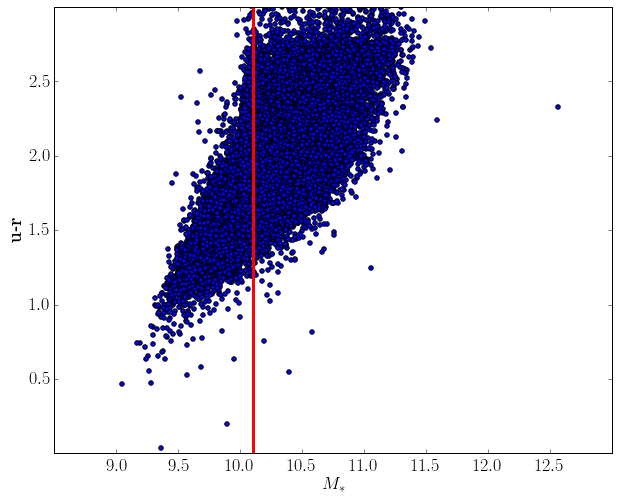

In [20]:
vl_sample = sample[in_volume_limit]
plt.scatter(vl_sample['LOGMSTAR_BALDRY06'],vl_sample['PETROMAG_MU']-vl_sample['PETROMAG_MR'])
_ = plt.ylim(0,3)
plt.vlines(10.1,0,3,color='r',linewidth=3)

plt.xlabel('$M_*$')
plt.ylabel('u-r')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


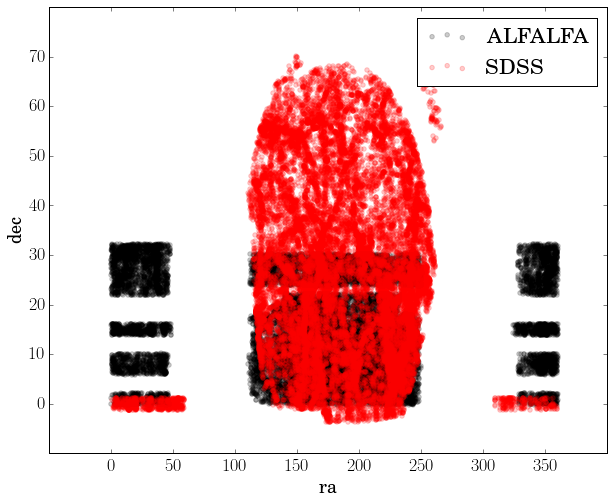

In [21]:
# Match up a70 w. our VLS?

_ = plt.scatter(alfalfa['HIra'],alfalfa['HIdec'],color='k',label='ALFALFA',alpha=0.2)
_ = plt.scatter(vl_sample['ra_1'],vl_sample['dec_1'],color='r',alpha=0.2,label='SDSS')
plt.xlabel('ra')
plt.ylabel('dec')
_ = plt.legend()

In [8]:
def get_errors(signal_to_noise):
    
    log_sn = np.log10(signal_to_noise)
    errors = np.zeros(len(log_sn))
    low_signal = log_sn < 1.6
    
    errors[low_signal == False] = 11
    errors[low_signal] = 71 - 79*log_sn[low_signal] + 26*(log_sn**2)[low_signal]
        
    return errors

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


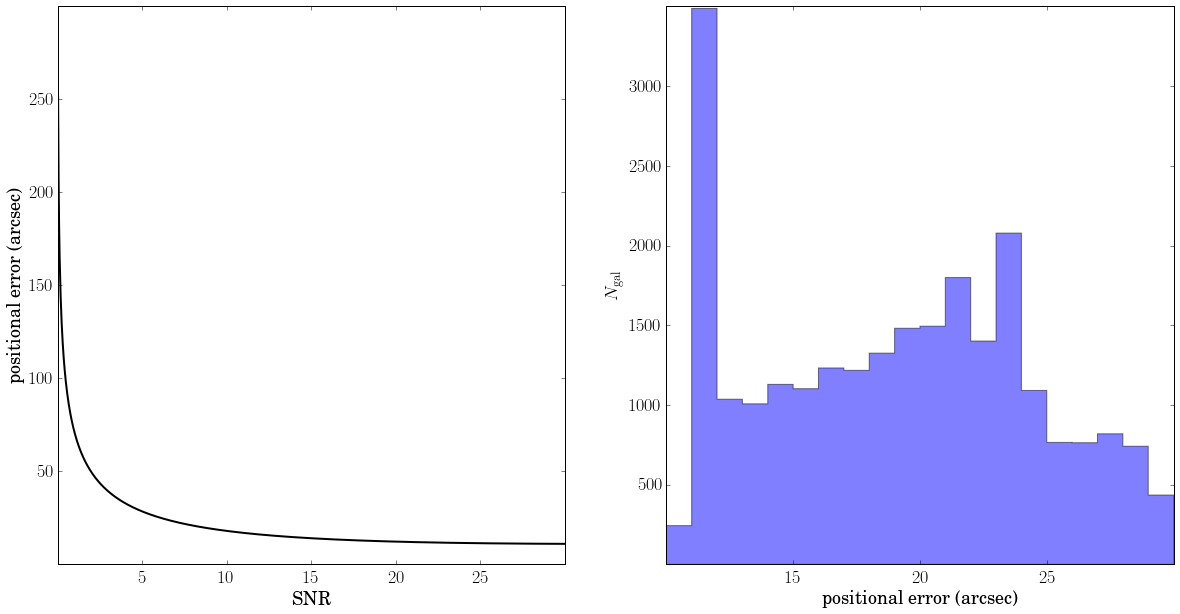

In [9]:
fig,axarr = plt.subplots(1,2,figsize=(20,10))

sns = np.linspace(0,30,1000)
errors = get_errors(sns)
plt.sca(axarr[0])
_ = plt.plot(sns,errors,'k-',lw=2)
plt.xlabel('SNR')
plt.ylabel('positional error (arcsec)')

pos_errors = get_errors(alfalfa['snratio'])
plt.sca(axarr[1])
_ = plt.hist(pos_errors,color='b',histtype='stepfilled',alpha=0.5,bins=np.linspace(10,30,21))
plt.xlabel('positional error (arcsec)')
plt.ylabel('$N_{\mathrm{gal}}$')

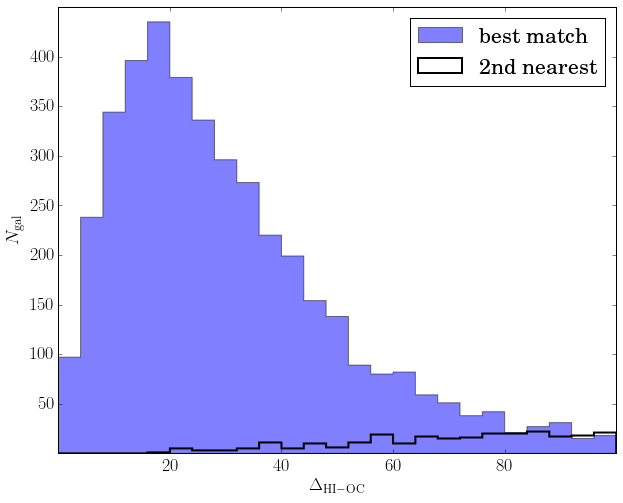

In [11]:
# Assign each of the ALFALFA detections a GZ galaxy:

gz_radec = ICRS(vl_sample['ra_1'],vl_sample['dec_1'],unit=(u.degree,u.degree))
a70_radec = ICRS(alfalfa['HIra'],alfalfa['HIdec'],unit=(u.degree,u.degree))
i1,d1,_ = match_coordinates_sky(a70_radec,gz_radec)
i2,d2,_ = match_coordinates_sky(a70_radec,gz_radec,nthneighbor=2)
# Plot up the values:
d1_arcsec = d1*3600
d2_arcsec = d2*3600
_ = plt.hist(d1_arcsec,bins=np.linspace(0,100,26),histtype='stepfilled',color='b',alpha=0.5,label='best match')
_ = plt.hist(d2_arcsec,bins=np.linspace(0,100,26),histtype='step',color='k',lw=2,label='2nd nearest')
_ = plt.legend()
plt.xlabel('$\Delta_{\mathrm{HI-OC}}$')
plt.ylabel('$N_{\mathrm{gal}}$')

i0 = range(len(i1))

matching_array = np.array([alfalfa['HIra'],alfalfa['HIdec'],i0,i1,d1_arcsec,d2_arcsec,pos_errors]).T
matching_table = Table(matching_array,names=('ra','dec','i_alfa','i_gz','d1','d2','error'))

In [12]:
# Now construct the masked array:
i_unique = np.unique(matching_table['i_gz'])
keep = []
for i in i_unique:
    i_indices = np.where(matching_table['i_gz'] == i)
    distances = matching_table['d1'][i_indices[0]]/matching_table['error'][i_indices[0]]
    best = np.argmin(distances)
    #if len(i_indices) == 1:
    keep.append(i_indices[0][best])
    
matching_table_ = matching_table[keep]

n_sigma = 2

multiple_object_mask = matching_table_['d2'] <= n_sigma*matching_table_['error']
print('{}/{} detections have 2+ objects in the within the positional error'.format(np.sum(multiple_object_mask),
                                                                                   len(multiple_object_mask)))

bad_match_mask = matching_table_['d1'] > n_sigma*matching_table_['error']
print('{}/{} detections have no objects within the positional error'.format(np.sum(bad_match_mask),
                                                                            len(bad_match_mask)))



bad = multiple_object_mask + bad_match_mask == True
good = multiple_object_mask + bad_match_mask == False
print("---> {}/{} detections with separations < {}sigma".format(np.sum(good),len(good),n_sigma))

good_matches = matching_table_[good]

25/8363 detections have 2+ objects in the within the positional error
5167/8363 detections have no objects within the positional error
---> 3171/8363 detections with separations < 2sigma


In [13]:
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_fractions(column,bins,th=0.5):
    
    fracs = np.zeros(len(np.unique(bins)))
    
    for m,b in enumerate(np.unique(bins)):
        
        bin_data = column[bins == b]
        fracs[m] = np.sum(bin_data > th)/len(bin_data)
        
    return fracs


def plot_by_column(x_column,y_column,color='k',label='___',nbins=10):

    x,bins = bin_by_column(x_column,nbins=nbins)
    x = []
    x_error = []
    y = []
    y_error = []

    for b in np.unique(bins):
    
        x.append(np.mean(x_column[bins == b]))
        x_error.append(np.std(x_column[bins == b]/np.sqrt(len(x_column[bins == b]))))
        y.append(np.mean(y_column[bins == b]))
        y_error.append(np.std(y_column[bins == b]/np.sqrt(len(y_column[bins == b]))))
        
    plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o',color=color,linewidth=2,label=label)
    
    return None


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def get_arm_fraction(column,bins,m):
    
    N_b = len(np.unique(bins))
    fractions = np.zeros(N_b)
    upper_fracs = np.zeros(N_b)
    lower_fracs = np.zeros(N_b)
    
    for n,b in enumerate(np.unique(bins)):
        
        bin_col = column[bins == b]
        bin_m = np.sum(bin_col == m)
        bin_tot = len(bin_col)
        
        f_low,f_high = get_fractional_errors(bin_m,bin_tot)
        fractions[n] = bin_m/bin_tot
        lower_fracs[n] = f_low
        upper_fracs[n] = f_high
    
    fractions_table = Table(np.array([lower_fracs,fractions,upper_fracs]).T
                            ,names=('low_f','f','high_f'))
    
    return fractions_table


def plot_by_column_abs(x_column,assignments,color='k',label='___',nbins=10,m_vals=[2]):
    
    x,bins = bin_by_column(x_column,nbins=nbins)
    
    n = []
    k = []
    
    for b in np.unique(bins):
        
        a_b = assignments[bins == b]
        in_m = a_b == 1000
        for m in m_vals:
            in_m = in_m + (a_b == m)
        k.append(len(a_b))
        n.append(np.sum(in_m))
        
    n = np.array(n)
    k = np.array(k)
    
    fractions = np.zeros(len(n))
    upper_fracs = np.zeros(len(n))
    lower_fracs = np.zeros(len(n))
    
    f = n/k
    f_low,f_high = get_fractional_errors(n,k)
    lower_fracs = f_low
    upper_fracs = f_high
        
    plt.errorbar(x,f,yerr=[f-f_low,f_high-f],fmt='o',color=color,linewidth=2,label=label)
    
    return None

In [14]:
def get_spiral_sample(data,questions,in_mass_limit=None,printout=True,p_th=None):

    in_volume_limit = data['in_volume_limit'] == True
    select_p = (data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
                *data['t02_edgeon_a05_no_debiased_rh']*data['t04_spiral_a08_spiral_debiased_rh']) > 0.5
    select_N = (data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count']) >= 5
    
    if in_mass_limit == None:
        select = (in_volume_limit) & (select_p) & (select_N)
    else:
        select = (in_volume_limit) & (select_p) & (select_N) & (in_mass_limit)
        
    answers = questions['t11_arms_number']['answers'][:-1]
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
    arm_array = np.array([data[A] for A in arm_answers]).T
    arm_assignments = np.argmax(arm_array,axis=1)
    if p_th != None:
        p_values = np.max(arm_array,axis=1)
        arm_assignments[p_values < p_th] = -999
        
    if printout:
        print('{}/{} selected'.format(np.sum(select),len(select)))
        for m in range(5):
            print('m={}: {}/{} spiral galaxies selected'.format(m+1,np.sum(arm_assignments[select] == m)
                                                         ,len(arm_assignments[select] == m)))
    
    return select,arm_assignments

In [15]:
matched_galaxies = vl_sample[good_matches['i_gz'].astype(int)]
select_spirals,m_values = get_spiral_sample(matched_galaxies,questions,p_th=0)
m_values = m_values[select_spirals]
bar_values = np.argmax(np.array([matched_galaxies[select_spirals]['t03_bar_' + a + '_debiased_rh'] 
                                 for a in ['a06_bar','a07_no_bar']]).T,axis=1)

859/3171 selected
m=1: 40/859 spiral galaxies selected
m=2: 427/859 spiral galaxies selected
m=3: 192/859 spiral galaxies selected
m=4: 63/859 spiral galaxies selected
m=5: 137/859 spiral galaxies selected


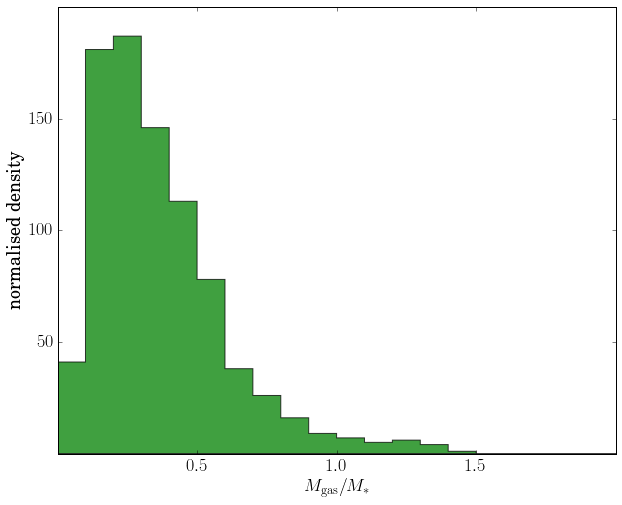

In [16]:
matched_alfa = good_matches['i_alfa'].astype(int)[select_spirals]
bins = np.linspace(0,2,21)

log_fgas = (alfalfa['loghimass'][matched_alfa] - matched_galaxies[select_spirals]['LOGMSTAR_BALDRY06'])
fgas = 10**log_fgas

_ = plt.hist(fgas,bins=bins,histtype='stepfilled',color='g',alpha=0.75)

plt.xlabel('$M_{\mathrm{gas}}/M_*$')
plt.ylabel('normalised density')

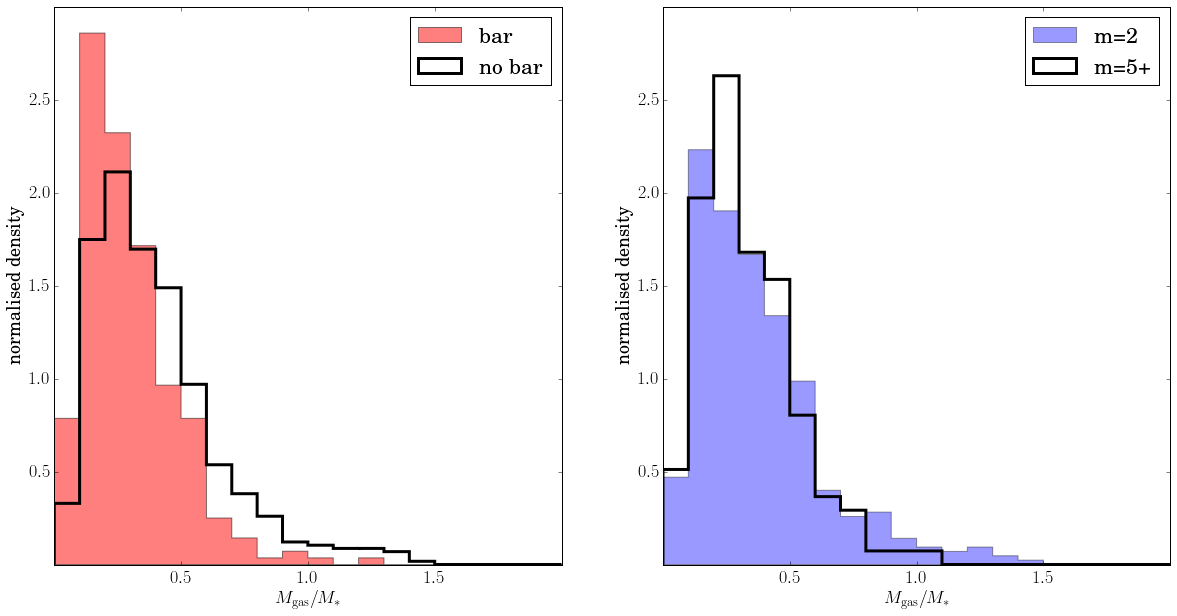

In [17]:
fig,axarr = plt.subplots(1,2,figsize=(20,10))

plt.sca(axarr[0])
_ = plt.hist(fgas[bar_values == 0],bins=bins,normed=True,
             histtype='stepfilled',color='r',alpha=0.5,label='bar')
_ = plt.hist(fgas[bar_values == 1],bins=bins,normed=True,
             histtype='step',lw=3,color='k',label='no bar')
plt.xlabel('$M_{\mathrm{gas}}/M_*$')
plt.ylabel('normalised density')
_ = plt.legend()

plt.sca(axarr[1])
_ = plt.hist(fgas[m_values == 1],bins=bins,normed=True,
             histtype='stepfilled',color='b',alpha=0.4,label='m=2')
_ = plt.hist(fgas[m_values == 4],bins=bins,normed=True,
             histtype='step',lw=3,color='k',label='m=5+')
plt.xlabel('$M_{\mathrm{gas}}/M_*$')
plt.ylabel('normalised density')
_ = plt.legend()

In [18]:
# Can we reproduce the results of Masters+10?

def get_f2_and_fbar(sample,questions):
    
    arg_columns = [1,0]
    f = []
    
    for i,Q in enumerate(['t11_arms_number','t03_bar']):
        
        answers = questions[Q]['answers']
        m_array = np.array([sample[Q + '_' + A + '_debiased_rh'] for A in answers]).T
        m_column = m_array[:,arg_columns[i]]
        f.append(m_column/np.sum(m_array,axis=1))
    
    f2,fbar = f
    return f2,fbar

In [19]:
def plot_by_column(x_column,y_column,color='k',label='___',nbins=10,logx=False,logy=False):
    
    if logx:
        x_column = np.log10(x_column)
    if logy:
        y_column = np.log10(y_column)
        
    select_finite = (np.isfinite(x_column)) & (np.isfinite(y_column))
    x_column = x_column[select_finite]
    y_column = y_column[select_finite]

    x,bins = bin_by_column(x_column,nbins=nbins)
    x = []
    x_error = []
    y = []
    y_error = []

    for b in np.unique(bins):
    
        x.append(np.mean(x_column[bins == b]))
        x_error.append(np.std(x_column[bins == b]/np.sqrt(len(x_column[bins == b]))))
        y.append(np.mean(y_column[bins == b]))
        y_error.append(np.std(y_column[bins == b]/np.sqrt(len(y_column[bins == b]))))
        
    plt.errorbar(x,y,xerr=x_error,yerr=y_error,fmt='o',color=color,linewidth=2,label=label)
    
    return None


def plot_2xy(ax,col1,col2,label1='f1',label2='f2',legend=True,nbins=8,logx=False,logy=False):
    
    plt.sca(ax)
    _ = plot_by_column(col1,col2,label='{} vs. {}'.format(label1,label2),
                       color='b',nbins=nbins,logx=logx,logy=logy)
    _ = plot_by_column(col2,col1,label='{} vs. {}'.format(label2,label1),
                       color='r',nbins=nbins,logx=logx,logy=logy)
    
    if legend:
        _ = plt.legend(fontsize=15)
    if logx:
        plt.xlabel('$\log(f)$')
    else:
        plt.xlabel('$f$')
    if logy:
        plt.ylabel('$\log(f)$')
    else:
        plt.ylabel('$f$')
    
    return None

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


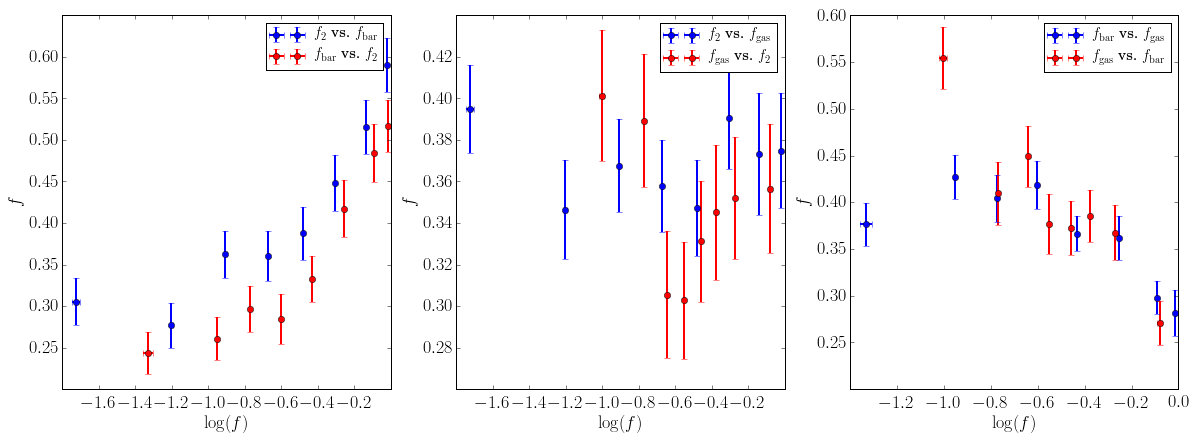

In [21]:
f2,fbar = get_f2_and_fbar(matched_galaxies[select_spirals],questions)

fig,axarr = plt.subplots(1,3,figsize=(20,6.7))

plot_2xy(axarr[0],f2,fbar,'$f_2$','$f_{\mathrm{bar}}$',logx=True)
plot_2xy(axarr[1],f2,fgas,'$f_2$','$f_{\mathrm{gas}}$',logx=True)
plot_2xy(axarr[2],fbar,fgas,'$f_{\mathrm{bar}}$','$f_{\mathrm{gas}}$',logx=True)

In [22]:
fractions_table = Table(np.array([f2,fbar,fgas]).T,names=('f2','fbar','fgas'))

def bin2d(x,y,z,xbins,ybins):
    
    x_a = np.digitize(x,xbins)
    y_a = np.digitize(y,ybins)

    z_values = np.ones((len(xbins),len(ybins)))*(-999)
    
    for x_assigned in np.unique(x_a):
        for y_assigned in np.unique(y_a):
            in_xy = (x_a == x_assigned) & (y_a == y_assigned)
            if np.sum(in_xy) > 0:
                z_values[x_assigned-1,y_assigned-1] = np.mean(z[in_xy])
            
    return z_values

In [43]:
from sklearn.neighbors.kde import KernelDensity
from astroML.linear_model import NadarayaWatson

def colour_contour(x,y,z,xlabel='$f_2$',ylabel='$f_{\mathrm{bar}}$',zlabel='$\log(f_{\mathrm{gas}})$'
                   ,h='minimise',cbar=True,plot_bandwidth=False):
    
    x_scaled,y_scaled = [scale(x),scale(y)]
    #x_scaled,y_scaled = [x,y]
    xy = np.array([x_scaled,y_scaled]).T
    
    x_grid_raw = np.linspace(np.min(x),np.max(x),100)
    y_grid_raw = np.linspace(np.min(y),np.max(y),100)
    
    x_grid = np.linspace(np.min(x_scaled),np.max(x_scaled),100)
    y_grid = np.linspace(np.min(y_scaled),np.max(y_scaled),100)
    x_g,y_g = np.array(np.meshgrid(x_grid,y_grid))
    xy_grid = np.array([x_g.ravel().squeeze(),y_g.ravel().squeeze()]).T
    
    if h == 'minimise':
        residuals,h_values = get_best_bandwidth(x_scaled,y_scaled,z)
        h = h_values[np.argmin(residuals)]
        print('best h found = {0:.2f}'.format(h))
    
    clf = NadarayaWatson('gaussian',h)
    clf.fit(xy,z)
    z_fit = clf.predict(xy_grid)

    plt.figure()
    plt.contourf(x_grid_raw,y_grid_raw,z_fit.reshape(100,100),levels=np.linspace(np.min(z_fit),np.max(z_fit),1000))

    if cbar:
        cb = plt.colorbar()
        cb.set_ticks(np.arange(-5,5,0.05))
        cb.set_label(zlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if plot_bandwidth:
        len_xb = h*np.std(x)/2
        len_yb = h*np.std(y)/2
        xmin,xmax = plt.gca().get_xlim()
        ymin,ymax = plt.gca().get_ylim()
        x_pos = xmin + 0.9*(xmax-xmin)
        y_pos = ymin + 0.9*(ymax-ymin)
        plt.hlines(y_pos,0.9-len_xb,0.9+len_xb,color='w',lw=2)
        plt.vlines(x_pos,0.9-len_yb,0.9+len_yb,color='w',lw=2)

In [44]:
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold

def get_best_bandwidth(x,y,z,plot=False):
    
    xy = np.array([x,y]).T
    
    kf = KFold(n=len(x),n_folds=3,shuffle=True,random_state=0)
    h_arr = np.logspace(-1,1,20)
    def get_h_residual(h_arr,kf):
        residuals = []
        for h in h_arr:
            residual = []
            for train,test in kf:
                training_xy = xy[train]
                training_z = z[train]
                test_xy = xy[test]
                test_z = z[test]
                clf = NadarayaWatson('gaussian',h=h)
                clf.fit(training_xy, training_z)
                z_fit = clf.predict(test_xy)
                
                residual.append(np.sum((test_z - z_fit)**2))
            residuals.append(np.sum(residual))
        return residuals
    
    residuals = get_h_residual(h_arr,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')
        
    h_arr_precise = np.linspace(h_arr[np.argmin(residuals)-1],h_arr[np.argmin(residuals)+1],20)
    residuals = get_h_residual(h_arr_precise,kf)
    if plot:
        plt.figure()
        plt.plot(h_arr_precise,residuals,lw=2)
        plt.xlabel('h')
        plt.ylabel('$\Sigma \chi ^2$')

    return residuals,h_arr_precise

best h found = 0.50


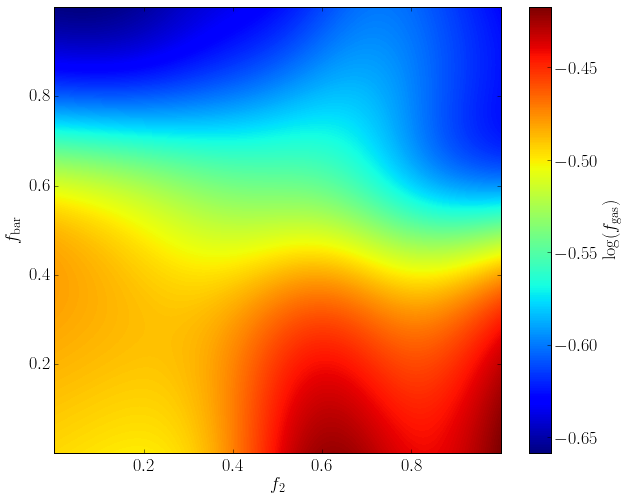

In [45]:
x = f2
y = fbar
z = log_fgas

colour_contour(x,y,z,plot_bandwidth=False)